# Basic Machine Learning for Predicting Thunderstorm Rotation

This module uses basic ML models &ndash; linear regression, logistic regression, decision trees, and random forests &ndash; to predict future rotation in numerically simulated thunderstorms from the National Center for Atmospheric Research (NCAR) convection-allowing ensemble (Schwartz *et al.* 2015).

# References

This notebook refers to a few publications, listed below.

Schwartz, C., G. Romine, M. Weisman, R. Sobash, K. Fossell, K. Manning, and S. Trier, 2015: "A real-time convection-allowing ensemble prediction system initialized by mesoscale ensemble Kalman filter analyses." *Weather and Forecasting*, **30 (5)**, 1158-1181.

# Setup

To use this notebook, you will need Python 3.6 and the following packages.

 - scipy
 - TensorFlow
 - Keras
 - scikit-image
 - netCDF4
 - pyproj
 - scikit-learn
 - opencv-python
 - matplotlib
 - shapely
 - geopy
 - metpy
 - descartes

If you have Anaconda on a Linux or Mac, you can install these packages with the commands `pip install scipy`, `pip install tensorflow`, etc.

# Imports

The next cell imports all libraries that will be used by this notebook.  If the notebook crashes anywhere, it will probably be here.

In [1]:
%matplotlib inline
import numpy
import utils

SEPARATOR_STRING = '\n\n' + '*' * 50 + '\n\n'
MINOR_SEPARATOR_STRING = '\n\n' + '-' * 50 + '\n\n'

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Find Training and Validation Data

The next cell finds data in the training (2010-14) and validation (2015) periods.

In [3]:
training_file_names = utils.find_many_feature_files(
    first_date_string='20100101', last_date_string='20141231')

validation_file_names = utils.find_many_feature_files(
    first_date_string='20150101', last_date_string='20151231')

# Read Validation Data

The next cell reads validation data and explores one of the files.

In [4]:
(validation_metadata_table, validation_predictor_table,
 validation_target_table
) = utils.read_many_feature_files(validation_file_names)

print(MINOR_SEPARATOR_STRING)
print('Variables in metadata are as follows:\n{0:s}'.format(
    str(list(validation_metadata_table))
))

print('\nPredictor variables are as follows:\n{0:s}'.format(
    str(list(validation_predictor_table))
))

print('\nTarget variable is as follows:\n{0:s}'.format(
    str(list(validation_target_table))
))

first_predictor_name = list(validation_predictor_table)[0]
these_predictor_values = (
    validation_predictor_table[first_predictor_name].values[:10]
)

message_string = (
    '\nValues of predictor variable "{0:s}" for the first few storm '
    'objects:\n{1:s}'
).format(first_predictor_name, str(these_predictor_values))
print(message_string)

target_name = list(validation_target_table)[0]
these_target_values = validation_target_table[target_name].values[:10]

message_string = (
    '\nValues of target variable ("{0:s}") for the first few storm '
    'objects:\n{1:s}'
).format(target_name, str(these_target_values))
print(message_string)

Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20150331-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20150416-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20150422-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20150505-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20150510-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20150523-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20150528-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20150605-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20150612-0000.csv"...
Reading data from: 

# Normalization

The next cell does the following:

 - Finds normalization parameters (mean and standard deviation for each predictor variable) for the training data.
 - Normalizes predictors for the first day in the training period.
 - Denormalizes predictors for the first day in the training period.
 - Ensures that denormalized values equal original values.

In [5]:
normalization_dict = utils.get_normalization_params(training_file_names)
print(MINOR_SEPARATOR_STRING)

first_training_predictor_table = utils.read_feature_file(
    training_file_names[0]
)[1]

predictor_names = list(first_training_predictor_table)
these_predictor_values = (
    first_training_predictor_table[predictor_names[0]].values[:10]
)

message_string = (
    '\nOriginal values of "{0:s}" for the first few storm objects:\n{1:s}'
).format(predictor_names[0], str(these_predictor_values))
print(message_string)

first_training_predictor_table, _ = utils.normalize_predictors(
    predictor_table=first_training_predictor_table,
    normalization_dict=normalization_dict)

these_predictor_values = (
    first_training_predictor_table[predictor_names[0]].values[:10]
)

message_string = (
    '\nNormalized values of "{0:s}" for the first few storm objects:\n{1:s}'
).format(predictor_names[0], str(these_predictor_values))
print(message_string)

first_training_predictor_table = utils.denormalize_predictors(
    predictor_table=first_training_predictor_table,
    normalization_dict=normalization_dict)

these_predictor_values = (
    first_training_predictor_table[predictor_names[0]].values[:10]
)

message_string = (
    '\nDenormalized values of "{0:s}" for the first few storm objects:'
    '\n{1:s}'
).format(predictor_names[0], str(these_predictor_values))
print(message_string)

Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101024-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101122-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110201-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110308-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110326-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110404-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110414-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110420-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110425-0000.csv"...
Reading data from: 

# Binarization

The next cell binarizes the target variable (max future rotation inside the storm).  "Binarization" means turning a real value into a 0 or 1, which allows the learning task to be simplified from regression to classification.

In [6]:
binarization_threshold = utils.get_binarization_threshold(
    csv_file_names=training_file_names, percentile_level=90.)
print(MINOR_SEPARATOR_STRING)

first_training_target_table = utils.read_feature_file(
    training_file_names[0]
)[-1]

these_target_values = (
    first_training_target_table[utils.TARGET_NAME].values[:10]
)

message_string = (
    '\nReal-numbered target values ("{0:s}") the first few storm objects:'
    '\n{1:s}'
).format(utils.TARGET_NAME, str(these_target_values))
print(message_string)

these_target_values = utils.binarize_target_values(
    target_values=these_target_values,
    binarization_threshold=binarization_threshold)

message_string = (
    '\nBinarized target values the first few storm objects:\n{0:s}'
).format(str(these_target_values))
print(message_string)

Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101024-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101122-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110201-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110308-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110326-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110404-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110414-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110420-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110425-0000.csv"...
Reading data from: 

# Linear Regression

In [9]:
training_predictor_table, training_target_table = (
    utils.read_many_feature_files(training_file_names)[1:]
)
print(MINOR_SEPARATOR_STRING)

validation_predictor_table, validation_target_table = (
    utils.read_many_feature_files(validation_file_names)[1:]
)
print(MINOR_SEPARATOR_STRING)

linreg_model_object = utils.setup_linear_regression(lambda1=0., lambda2=0.)
utils.train_linear_regression(
    model_object=linreg_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

training_predictions = linreg_model_object.predict(
    training_predictor_table.as_matrix()
)
mean_training_target_value = numpy.mean(
    training_target_table[utils.TARGET_NAME].values
)

_ = utils.evaluate_regression(
    target_values=training_target_table[utils.TARGET_NAME].values,
    predicted_target_values=training_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='training')
print(MINOR_SEPARATOR_STRING)

validation_predictions = linreg_model_object.predict(
    validation_predictor_table.as_matrix()
)

_ = utils.evaluate_regression(
    target_values=validation_target_table[utils.TARGET_NAME].values,
    predicted_target_values=validation_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='validation')

Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101024-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101122-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110201-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110308-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110326-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110404-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110414-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110420-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110425-0000.csv"...
Reading data from: 

Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20150630-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20150706-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20150712-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20151031-0000.csv"...
Reading data from: "../data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20151227-0000.csv"...


--------------------------------------------------


Training MAE (mean absolute error) = 0.001 s^-1
Training MSE (mean squared error) = 1.112e-06 s^-2
Training bias (mean signed error) = 0.000 s^-1
Training MAE skill score (improvement over climatology) = 0.315
Training MSE skill score (improvement over climatology) = 0.521


--------------------------------------------------


Validation MAE (mean absolute error) = 0.001 s^-1
Validation MSE (mean 

/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:510: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


# Linear Regression: Plotting Coefficients

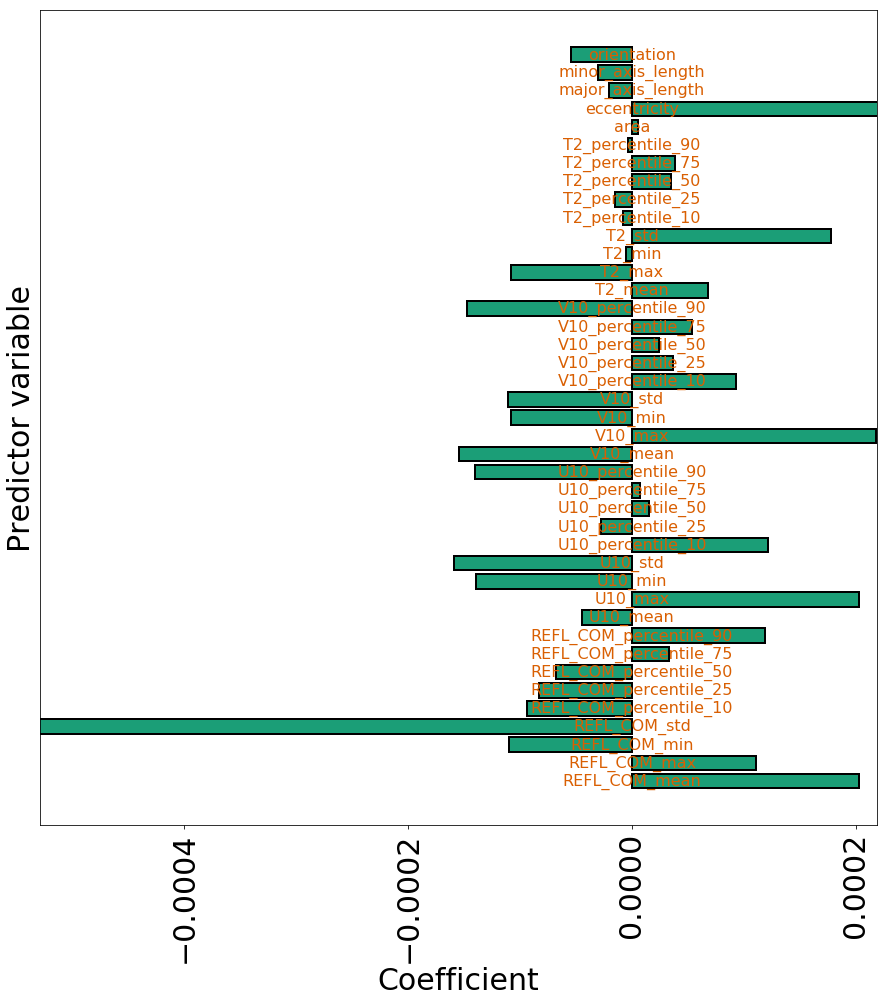

In [10]:
utils.plot_model_coefficients(
    model_object=linreg_model_object,
    predictor_names=list(training_predictor_table)
)

# Linear Regression with Ridge Penalty ("Ridge Regression")

In [11]:
ridge_model_object = utils.setup_linear_regression(
    lambda1=0., lambda2=0.001)

utils.train_linear_regression(
    model_object=ridge_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

training_predictions = ridge_model_object.predict(
    training_predictor_table.as_matrix()
)
mean_training_target_value = numpy.mean(
    training_target_table[utils.TARGET_NAME].values
)

_ = utils.evaluate_regression(
    target_values=training_target_table[utils.TARGET_NAME].values,
    predicted_target_values=training_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='training')
print(MINOR_SEPARATOR_STRING)

validation_predictions = ridge_model_object.predict(
    validation_predictor_table.as_matrix()
)

_ = utils.evaluate_regression(
    target_values=validation_target_table[utils.TARGET_NAME].values,
    predicted_target_values=validation_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='validation')

Training MAE (mean absolute error) = 0.001 s^-1
Training MSE (mean squared error) = 1.112e-06 s^-2
Training bias (mean signed error) = 0.000 s^-1
Training MAE skill score (improvement over climatology) = 0.315
Training MSE skill score (improvement over climatology) = 0.521


--------------------------------------------------


Validation MAE (mean absolute error) = 0.001 s^-1
Validation MSE (mean squared error) = 1.048e-06 s^-2
Validation bias (mean signed error) = -0.000 s^-1
Validation MAE skill score (improvement over climatology) = 0.316
Validation MSE skill score (improvement over climatology) = 0.540


/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:510: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


# "Ridge Regression": Plotting Coefficients

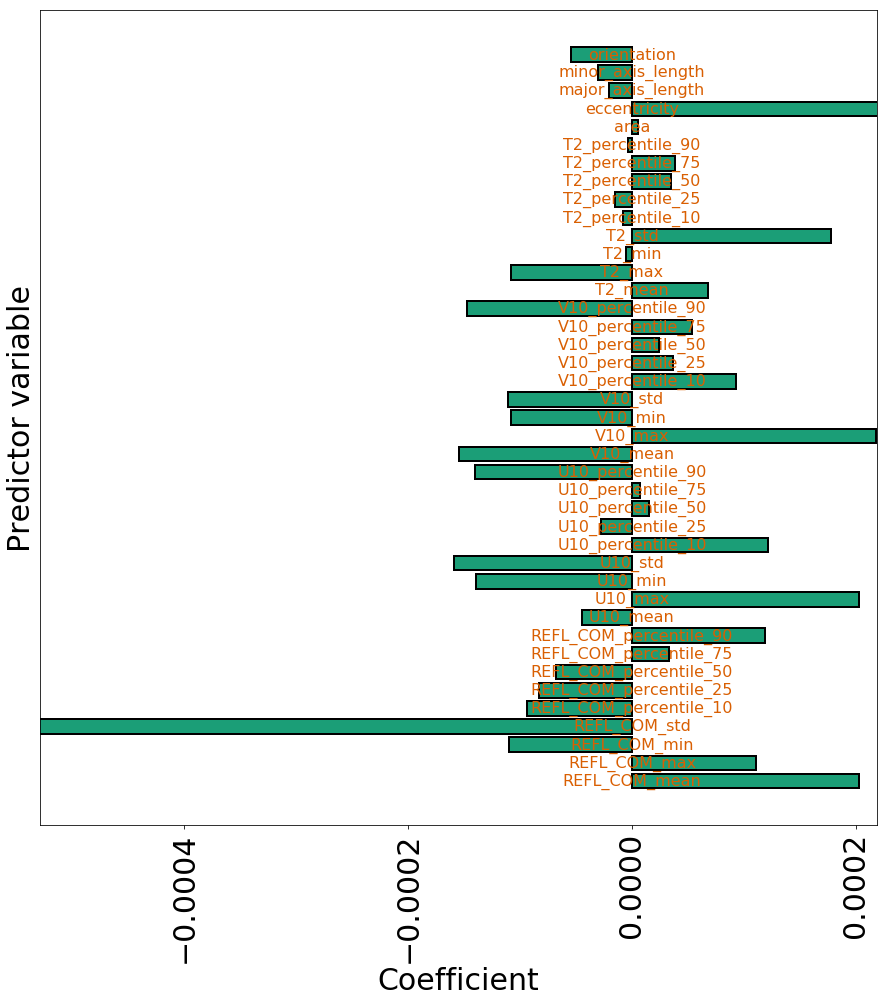

In [12]:
utils.plot_model_coefficients(
    model_object=ridge_model_object,
    predictor_names=list(training_predictor_table)
)

# Linear Regression with Lasso Penalty ("Lasso Regression")

In [13]:
lasso_model_object = utils.setup_linear_regression(
    lambda1=0.001, lambda2=0.)

utils.train_linear_regression(
    model_object=lasso_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

training_predictions = lasso_model_object.predict(
    training_predictor_table.as_matrix()
)
mean_training_target_value = numpy.mean(
    training_target_table[utils.TARGET_NAME].values
)

_ = utils.evaluate_regression(
    target_values=training_target_table[utils.TARGET_NAME].values,
    predicted_target_values=training_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='training')
print(MINOR_SEPARATOR_STRING)

validation_predictions = lasso_model_object.predict(
    validation_predictor_table.as_matrix()
)

_ = utils.evaluate_regression(
    target_values=validation_target_table[utils.TARGET_NAME].values,
    predicted_target_values=validation_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='validation')

Training MAE (mean absolute error) = 0.001 s^-1
Training MSE (mean squared error) = 1.379e-06 s^-2
Training bias (mean signed error) = -0.000 s^-1
Training MAE skill score (improvement over climatology) = 0.252
Training MSE skill score (improvement over climatology) = 0.406


--------------------------------------------------


Validation MAE (mean absolute error) = 0.001 s^-1
Validation MSE (mean squared error) = 1.336e-06 s^-2
Validation bias (mean signed error) = -0.000 s^-1
Validation MAE skill score (improvement over climatology) = 0.248
Validation MSE skill score (improvement over climatology) = 0.414


/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:510: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


# "Lasso Regression": Plotting Coefficients

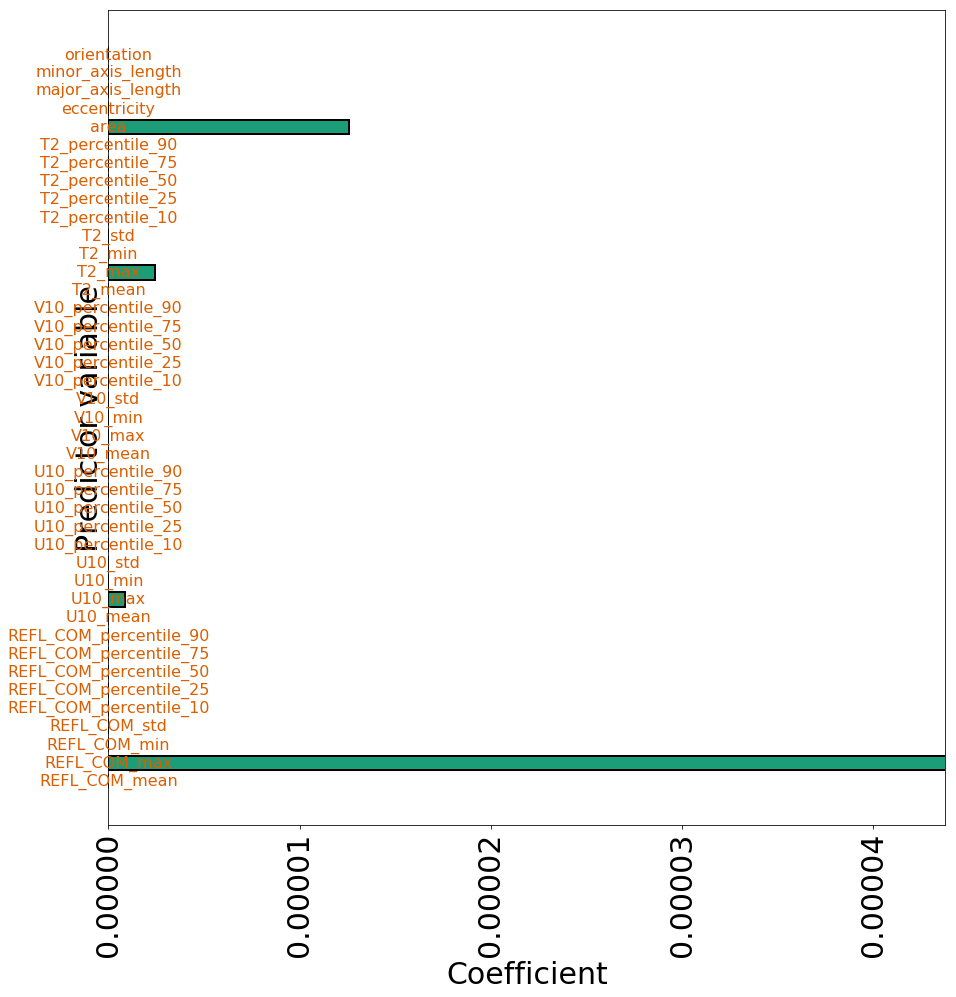

In [14]:
utils.plot_model_coefficients(
    model_object=lasso_model_object,
    predictor_names=list(training_predictor_table)
)

# Linear Regression with Elastic-net Penalty ("Elastic-net Regression")

In [19]:
elastic_net_model_object = utils.setup_linear_regression(
    lambda1=1e-5, lambda2=1e-3)

utils.train_linear_regression(
    model_object=elastic_net_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table)

training_predictions = elastic_net_model_object.predict(
    training_predictor_table.as_matrix()
)
mean_training_target_value = numpy.mean(
    training_target_table[utils.TARGET_NAME].values
)

_ = utils.evaluate_regression(
    target_values=training_target_table[utils.TARGET_NAME].values,
    predicted_target_values=training_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='training')
print(MINOR_SEPARATOR_STRING)

validation_predictions = elastic_net_model_object.predict(
    validation_predictor_table.as_matrix()
)

_ = utils.evaluate_regression(
    target_values=validation_target_table[utils.TARGET_NAME].values,
    predicted_target_values=validation_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='validation')

/localdata/ryan.lagerquist/sea_tutorial/module_2/utils.py:510: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X=training_predictor_table.as_matrix(),


Training MAE (mean absolute error) = 0.001 s^-1
Training MSE (mean squared error) = 1.125e-06 s^-2
Training bias (mean signed error) = -0.000 s^-1
Training MAE skill score (improvement over climatology) = 0.312
Training MSE skill score (improvement over climatology) = 0.515


--------------------------------------------------


Validation MAE (mean absolute error) = 0.001 s^-1
Validation MSE (mean squared error) = 1.062e-06 s^-2
Validation bias (mean signed error) = 0.000 s^-1
Validation MAE skill score (improvement over climatology) = 0.312
Validation MSE skill score (improvement over climatology) = 0.534


/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
/home/ryan.lagerquist/anaconda3_short_course/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


# "Elastic-net Regression": Plotting Coefficients

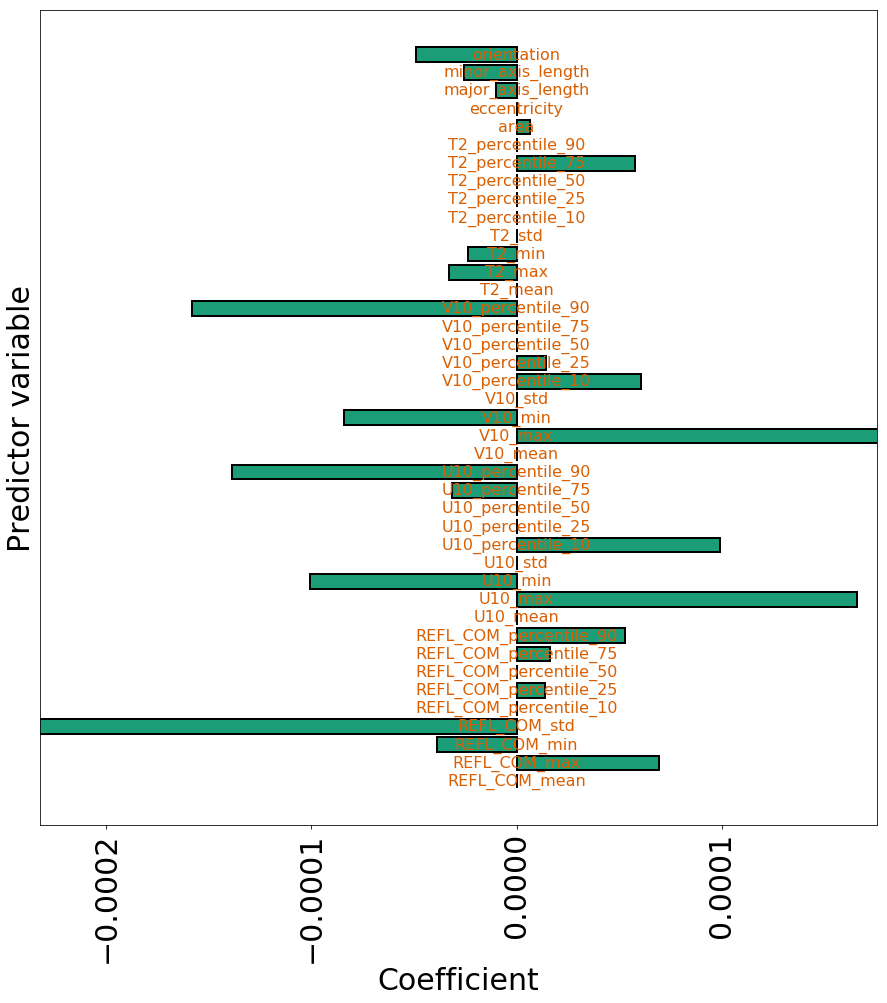

In [20]:
utils.plot_model_coefficients(
    model_object=elastic_net_model_object,
    predictor_names=list(training_predictor_table)
)